#Scripts de PyPlot para hacer figuras chingonas para poster

Primero, vamos a intentarlo con un experimento que tenga una actividad notoria. Aquí cargamos un archivo que contiene los datos de un experimento con actividad epiléptica. La región CA aparece muy activa varias veces en las mediciones del potencial de campo local, LFP de ahora en adelante.

In [2]:
using PyPlot

In [3]:
muacamuaca=open("../Actividad4AP/DatosActividadEpilepticaSelectos.bin", "r")
formaarray=(64,64,5001)
DatosExperimentales=read(muacamuaca, Float64, formaarray);
close(muacamuaca)

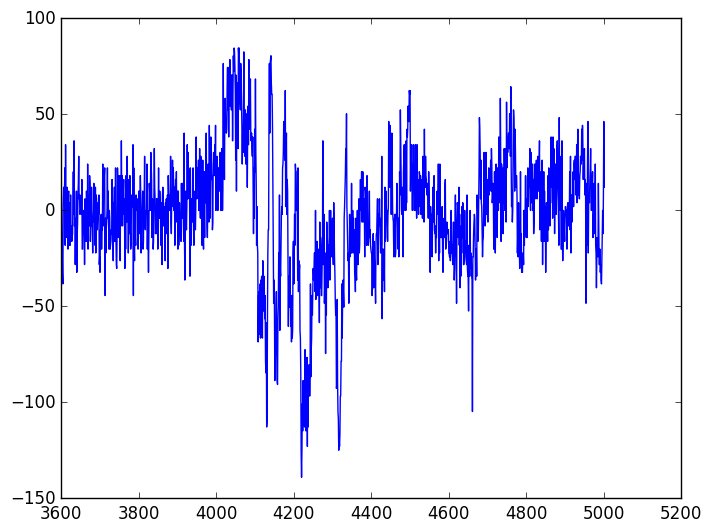

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdb9c2e1f60>

In [4]:
#No todos los datos son interesantes
ion()
intervalo=3600:5001
plot(intervalo, vec(DatosExperimentales[52,40,intervalo]))

Por consistencia, vamos a transponer todos los datos para que las imagenes coincidan con las de Franco

In [6]:
DatosExperimentales=DatosExperimentales[:,:,intervalo];
(alto,ancho,tmax)=size(DatosExperimentales)
map!(x-> abs(x)>1750? 0: x, DatosExperimentales);

LoadError: LoadError: BoundsError: attempt to access 64x64x1402 Array{Float64,3}:
[:, :, 1] =
   0.0       -8.05664   14.0991   …  -12.085     -2.01416   -8.05664
   2.01416  -10.0708    -6.04248      -6.04248   -6.04248  -14.0991 
   8.05664    6.04248   20.1416      -32.2266     8.05664    2.01416
  10.0708   -10.0708     0.0          18.1274     0.0       16.1133 
 -16.1133    12.085     34.2407        2.01416    2.01416  -12.085  
  -4.02832  -20.1416    -8.05664  …    8.05664    2.01416  -12.085  
  -4.02832  -22.1558     0.0           4.02832    0.0        6.04248
   0.0      -12.085     -6.04248     -10.0708    -6.04248  -22.1558 
 -12.085     26.1841    12.085        12.085    -12.085      0.0    
 -14.0991     4.02832    4.02832      32.2266    -2.01416    2.01416
  10.0708     0.0        0.0      …    4.02832    2.01416  -22.1558 
   4.02832    8.05664  -10.0708       10.0708     4.02832   -8.05664
  10.0708     6.04248   -4.02832      38.269     12.085      8.05664
   ⋮                              ⋱                                 
 -14.0991   -12.085    -10.0708       48.3398     6.04248   -2.01416
   0.0       16.1133   -10.0708        8.05664    6.04248  -16.1133 
 -26.1841     8.05664   16.1133      -16.1133     2.01416   -2.01416
  16.1133   -18.1274     4.02832  …    8.05664    6.04248   -4.02832
 -14.0991     0.0        2.01416      12.085      0.0      -14.0991 
   4.02832  -22.1558   -12.085         8.05664   12.085      0.0    
 -20.1416     2.01416   -8.05664       8.05664  -14.0991   -16.1133 
 -12.085     -2.01416  -20.1416        0.0      -28.1982    26.1841 
 -12.085      8.05664    2.01416  …  -40.2832     2.01416   -4.02832
 -34.2407   -10.0708     8.05664      -2.01416  -24.1699    -2.01416
  12.085      8.05664  -26.1841      -10.0708   -18.1274    -2.01416
  -8.05664  -14.0991    20.1416      -14.0991   -18.1274   -20.1416 

[:, :, 2] =
   0.0       20.1416    -4.02832  …   22.1558    14.0991    22.1558 
  20.1416    14.0991     6.04248      -2.01416    0.0        4.02832
  46.3257    16.1133    -4.02832      22.1558     8.05664   -4.02832
 -24.1699    16.1133     4.02832       2.01416   14.0991   -16.1133 
  20.1416    -4.02832   20.1416        0.0       -6.04248   10.0708 
  10.0708    20.1416     2.01416  …   -8.05664   14.0991    10.0708 
  14.0991    28.1982    14.0991       -8.05664   30.2124    18.1274 
 -10.0708     6.04248   -8.05664     -24.1699     4.02832   14.0991 
 -12.085    -10.0708     8.05664       2.01416    2.01416  -14.0991 
  26.1841   -30.2124    -2.01416       8.05664  -12.085     -8.05664
 -10.0708   -16.1133    -2.01416  …    2.01416   14.0991   -14.0991 
 -12.085     -2.01416    0.0         -12.085      4.02832  -12.085  
 -10.0708    16.1133     2.01416      18.1274    16.1133    -8.05664
   ⋮                              ⋱                                 
  14.0991    -2.01416   20.1416        0.0      -26.1841   -22.1558 
  10.0708    16.1133     4.02832     -36.2549   -30.2124   -14.0991 
   4.02832  -22.1558     6.04248     -10.0708   -14.0991   -22.1558 
  12.085    -28.1982     4.02832  …  -46.3257     4.02832    0.0    
  -2.01416    0.0       12.085         0.0        0.0       -8.05664
  -4.02832   16.1133   -14.0991      -24.1699   -32.2266    -8.05664
   2.01416    0.0      -24.1699      -30.2124     0.0       -8.05664
   6.04248    2.01416  -14.0991       -2.01416   -2.01416    8.05664
 -14.0991   -10.0708    -4.02832  …   12.085    -24.1699   -14.0991 
  -8.05664  -12.085      4.02832     -18.1274   -28.1982   -16.1133 
 -24.1699    -8.05664  -28.1982      -42.2974   -28.1982     2.01416
 -30.2124   -16.1133   -10.0708      -32.2266   -22.1558   -10.0708 

[:, :, 3] =
   0.0        2.01416  -24.1699   …  -42.2974   -36.2549   -14.0991 
 -20.1416   -32.2266   -18.1274      -28.1982   -14.0991    20.1416 
 -32.2266    -4.02832   18.1274      -10.0708   -14.0991    -8.05664
 -30.2124   -22.1558    10.0708      -18.1274    -6.04248  -12.085  
 -10.0708    10.0708     0.0          -4.02832   20.1416    12.085  
  22.1558    10.0708   -10.0708   …   16.1133    12.085      6.04248
 -10.0708     0.0      -10.0708       14.0991    -4.02832   -8.05664
   0.0       -6.04248    6.04248     -14.0991     0.0       -6.04248
  34.2407     0.0       14.0991      -22.1558    -4.02832   -8.05664
  42.2974    20.1416    10.0708       26.1841     6.04248   22.1558 
   4.02832   12.085     16.1133   …   -4.02832    4.02832   20.1416 
  -8.05664    8.05664  -20.1416       16.1133    46.3257    -2.01416
   4.02832    8.05664   20.1416        6.04248    8.05664   -6.04248
   ⋮                              ⋱                                 
   0.0        0.0       -6.04248     -30.2124   -10.0708    12.085  
  -6.04248   -6.04248  -22.1558       10.0708     6.04248    0.0    
  12.085     38.269      8.05664      -4.02832    4.02832    4.02832
   2.01416   -6.04248  -16.1133   …   -8.05664  -16.1133    24.1699 
  10.0708   -16.1133    22.1558      -20.1416    40.2832     6.04248
  16.1133     0.0      -22.1558       20.1416   -12.085     -8.05664
 -16.1133    26.1841     8.05664       2.01416   16.1133    16.1133 
  -4.02832    8.05664   18.1274       20.1416    12.085      2.01416
  20.1416    16.1133    40.2832   …  -16.1133   -24.1699     4.02832
  20.1416    26.1841    18.1274        0.0        4.02832   12.085  
   8.05664    2.01416   24.1699        2.01416   12.085     12.085  
  24.1699     2.01416    6.04248       6.04248   26.1841    20.1416 

...

[:, :, 1400] =
   0.0      -10.0708   -20.1416   …  -28.1982    -6.04248    2.01416
  12.085      4.02832  -24.1699        0.0       -4.02832   22.1558 
 -22.1558     6.04248   14.0991      -34.2407   -14.0991    -4.02832
 -20.1416   -22.1558     8.05664      -4.02832    2.01416    0.0    
  14.0991   -18.1274    -2.01416       2.01416    8.05664    2.01416
   8.05664    6.04248   10.0708   …  -18.1274   -18.1274   -22.1558 
   0.0       12.085     12.085        38.269      8.05664    2.01416
  -4.02832  -22.1558    24.1699      -10.0708    16.1133    -4.02832
   0.0       14.0991   -10.0708      -10.0708   -10.0708     4.02832
  -4.02832    0.0      -24.1699      -12.085      8.05664    0.0    
 -22.1558    -6.04248   -8.05664  …  -20.1416   -10.0708   -14.0991 
 -10.0708    22.1558    24.1699      -10.0708   -10.0708   -40.2832 
 -28.1982   -16.1133     4.02832      22.1558    10.0708   -12.085  
   ⋮                              ⋱                                 
 -28.1982    -6.04248  -20.1416       24.1699   -30.2124    -2.01416
  -2.01416   -6.04248   24.1699      -16.1133     2.01416   -8.05664
  -8.05664   -8.05664   -4.02832     -16.1133     4.02832  -16.1133 
 -24.1699    12.085    -14.0991   …   -4.02832   10.0708     4.02832
 -18.1274    -4.02832  -14.0991      -18.1274     6.04248    0.0    
 -26.1841   -10.0708     2.01416       4.02832   18.1274     0.0    
   4.02832   16.1133     8.05664      18.1274    10.0708    24.1699 
  -4.02832   22.1558    22.1558        0.0        4.02832   16.1133 
 -24.1699   -16.1133    -6.04248  …   -6.04248   -4.02832   20.1416 
   8.05664   14.0991    -8.05664       2.01416   14.0991    10.0708 
   0.0       -6.04248    2.01416      -6.04248   14.0991    -6.04248
  16.1133     4.02832   10.0708        2.01416   14.0991    12.085  

[:, :, 1401] =
   0.0      -12.085      6.04248  …  -22.1558    -6.04248   -8.05664
 -12.085    -20.1416     0.0          -4.02832   -8.05664  -20.1416 
  -8.05664   -4.02832    2.01416      -6.04248   -4.02832  -18.1274 
  24.1699     8.05664    2.01416      -2.01416   -4.02832  -12.085  
 -26.1841     0.0       22.1558      -16.1133   -24.1699   -18.1274 
  24.1699    -8.05664  -20.1416   …   -6.04248  -12.085      2.01416
  28.1982     6.04248  -24.1699        2.01416   18.1274   -10.0708 
   6.04248   -6.04248    2.01416       0.0        4.02832   36.2549 
  18.1274    10.0708    -2.01416       2.01416    6.04248  -14.0991 
  -8.05664    2.01416    8.05664     -16.1133    32.2266     8.05664
   0.0        0.0      -24.1699   …    0.0        6.04248   -8.05664
 -14.0991     6.04248   12.085        12.085     28.1982    16.1133 
  24.1699    14.0991     8.05664     -22.1558     2.01416    0.0    
   ⋮                              ⋱                                 
  -6.04248   -4.02832   16.1133      -16.1133    14.0991    -2.01416
   0.0      -26.1841   -10.0708       -2.01416  -10.0708    -8.05664
 -30.2124   -20.1416    -2.01416     -22.1558    -2.01416    0.0    
   2.01416  -36.2549   -32.2266   …  -18.1274   -22.1558   -14.0991 
 -18.1274   -22.1558   -12.085       -14.0991   -30.2124   -22.1558 
 -14.0991     8.05664  -28.1982       14.0991    -8.05664  -18.1274 
  -4.02832   -6.04248   18.1274      -16.1133    -2.01416  -30.2124 
  -8.05664  -26.1841   -18.1274      -32.2266   -32.2266   -16.1133 
 -12.085    -22.1558    18.1274   …   -8.05664   -8.05664    4.02832
 -24.1699   -14.0991   -22.1558       -4.02832  -16.1133   -16.1133 
 -26.1841    -4.02832  -14.0991       -2.01416    0.0       -2.01416
  20.1416     8.05664   12.085       -20.1416    10.0708     0.0    

[:, :, 1402] =
   0.0        4.02832  -30.2124   …  -16.1133     2.01416   -6.04248
 -26.1841   -22.1558    16.1133        0.0       -8.05664   -8.05664
  -6.04248   20.1416   -14.0991       -6.04248  -16.1133   -36.2549 
 -18.1274    24.1699    18.1274      -22.1558     6.04248  -14.0991 
 -22.1558   -10.0708   -20.1416       10.0708     2.01416    6.04248
  14.0991     0.0        8.05664  …   14.0991     2.01416  -28.1982 
   8.05664   12.085     -2.01416      10.0708    -4.02832  -14.0991 
 -22.1558     0.0        4.02832      18.1274   -18.1274     2.01416
  -2.01416   -2.01416  -20.1416       -4.02832    0.0      -18.1274 
  22.1558    -6.04248  -12.085         8.05664   -2.01416    2.01416
   0.0       14.0991   -16.1133   …    6.04248   -2.01416  -10.0708 
  -2.01416  -16.1133    24.1699       10.0708    20.1416    10.0708 
  12.085      4.02832   12.085         8.05664   18.1274     0.0    
   ⋮                              ⋱                                 
 -22.1558   -42.2974    14.0991      -22.1558   -22.1558    26.1841 
   0.0      -20.1416    20.1416      -12.085      4.02832  -28.1982 
 -14.0991   -20.1416    -2.01416     -10.0708    -4.02832  -16.1133 
 -36.2549    -4.02832  -20.1416   …  -22.1558   -14.0991     8.05664
  -2.01416  -10.0708   -20.1416       -2.01416   -8.05664  -26.1841 
 -12.085     20.1416    -8.05664       2.01416  -18.1274     4.02832
 -20.1416   -24.1699     6.04248     -12.085     -2.01416  -16.1133 
  -8.05664  -16.1133   -24.1699      -10.0708     6.04248  -40.2832 
 -10.0708   -18.1274   -44.3115   …  -26.1841   -42.2974   -20.1416 
   0.0      -12.085    -44.3115      -26.1841   -28.1982   -28.1982 
 -20.1416   -22.1558   -14.0991      -16.1133    -8.05664  -34.2407 
 -10.0708   -22.1558   -22.1558       -8.05664   -8.05664  -14.0991 
  at index [Colon(),Colon(),3600:5001]
while loading In[6], in expression starting on line 1

In [7]:
for t=1:tmax
    DatosExperimentales[:,:,t]=transpose(DatosExperimentales[:,:,t])
end

In [8]:
function ListaPixelesdeLinea(x::Array, y::Array)
    #obtener una lista de pixeles/electrodos a lo largo de una linea con dos endpoints enteros.
    #Se ponen las dos coordenadas x en un arreglo y las dos y en otro-
    xuno, xdos=x[1], x[2]
    yuno, ydos=y[1],y[2]
    longitud=abs(xuno-xdos)
    m=(ydos-yuno)/(xdos-xuno)
    xresult=collect(xuno:xdos) #asumimos que el xdos es el grande!
    yresult=zeros(Int, longitud+1)
    for j in 1:longitud+1
        yresult[j]=round(Int,yuno+(j-1)*m)
    end
    return (xresult,yresult)
end

ListaPixelesdeLinea (generic function with 1 method)

In [9]:
dobleprimax=[44,48,52,54,58, 63]
dobleprimay=[38,42,45,47,50, 54]
dobleprimal=["F''","E''", "D''", "C''", "B''","A''"];
primax=[32, 32, 32, 32, 32, 32]
primay=[43,47,51,55,59,63]
primal=["F'","E'", "D'", "C'", "B'","A'"];
puntox=[44,48,52,55,58,62]
puntoy=[38,36,34,32,30,28]
puntol=["F","E", "D", "C", "B","A"];

In [10]:
muchasx,muchasy=ListaPixelesdeLinea([44,63],[38,28])
size(muchasx)

(20,)

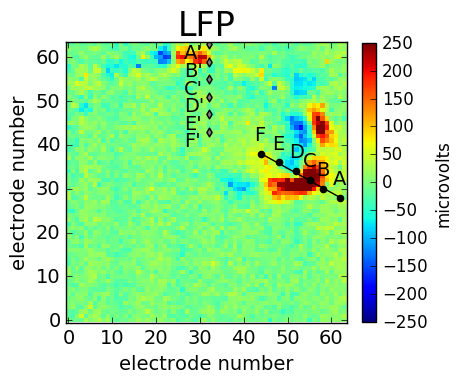

In [42]:
figure(figsize=(4.0,3.66))
font1 = Dict("family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>24)

title("LFP", fontdict=font1)
limites=250
PyPlot.xlim(-0.5,63.5)
PyPlot.ylim(-0.5,63.5)

tau=550

for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points", fontsize=14)
    annotate(primal[punto], (primax[punto], primay[punto]-2), xytext=(-18,-4), textcoords="offset points", fontsize=14)
    #annotate(dobleprimal[punto], (dobleprimax[punto], dobleprimay[punto]), xytext=(-18,-4), 
    # textcoords="offset points", fontsize=14)
end
imagen=imshow((DatosExperimentales[:,:,tau]), 
interpolation="none", cmap="jet", origin="lower", vmin=-limites, vmax=limites)
tick_params(axis="both", labelsize=14)

scatter(puntox,puntoy, marker="o", s=20, c="black")
scatter(primax,primay, marker="d", s=20, c="grey")
#scatter(dobleprimax,dobleprimay, marker="s", s=20, c="grey")


plot([puntox[1], puntox[end]], [puntoy[1], puntoy[end]], "k-")

cbx=colorbar(imagen, fraction=0.045) 
cbx[:set_label]("microvolts")
tick_params(axis="both", labelsize=14)

xlabel("electrode number", fontsize=14)
ylabel("electrode number", fontsize=14)

#savefig("LFP_ForDiagram_$tau_01.svg", dpi=90)

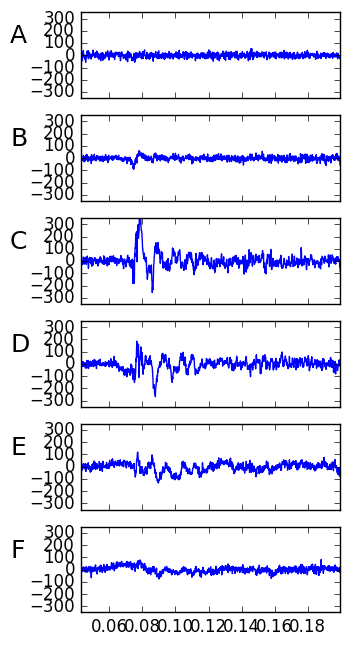

In [45]:
tiempo=1:tmax
t=700

farofa, lista=subplots(6, sharex=true, sharey=true, figsize=(3.35,6*1.25))

for j=1:6
    PyPlot.xlim(300/7022,tmax/7022)
    PyPlot.ylim(-350,350)
    lista[j][:plot](tiempo/7022,vec(DatosExperimentales[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j][:annotate](puntol[7-j],xy=(0.0,100), annotation_clip=false, fontsize=18)
end


#savefig("LFP_A-F_Points_01.svg",dpi=90)

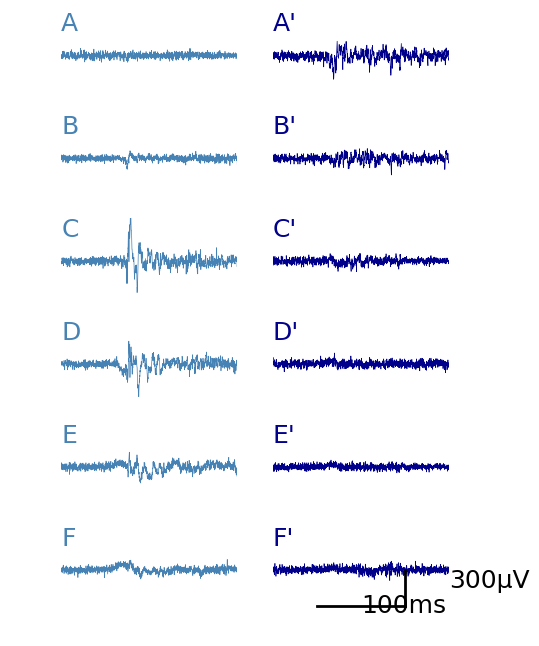

In [56]:
tiempo=1:tmax
t=700

farofa, lista=subplots(6,2, sharex=true, sharey=true, figsize=(5,6*1.25))

for j=1:6
    PyPlot.xlim(1/7022,tmax/7022)
    PyPlot.ylim(-350,350)
    lista[j,1][:plot](tiempo/7022,vec(DatosExperimentales[puntoy[7-j],puntox[7-j],tiempo]), color="steelblue", lw=0.5)
    lista[j,1][:annotate](puntol[7-j],xy=(0.0,200), annotation_clip=false, fontsize=18,color="steelblue")
    lista[j,1][:axis]("off")
    
    lista[j,2][:plot](tiempo/7022,vec(DatosExperimentales[primay[7-j],primax[7-j],tiempo]),lw=0.5, color="darkblue")
    lista[j,2][:annotate](primal[7-j],xy=(0.00,200), annotation_clip=false, fontsize=18,color="darkblue")
    lista[j,2][:axis]("off")
    
  #  lista[j,3][:plot](tiempo/7022,vec(DatosExperimentales[dobleprimay[7-j],dobleprimax[7-j],tiempo]))
  #  lista[j,3][:annotate](dobleprimal[7-j],xy=(0.0,200), annotation_clip=false, fontsize=18)
end

lista[6,2][:plot]([0.05,0.15],[-300,-300], color="black", lw=2)
lista[6,2][:plot]([0.15,0.15],[-300,0], color="black", lw=2)
lista[6,2][:annotate]("300µV", xy=(0.20,-150),annotation_clip=false, fontsize=18)
lista[6,2][:annotate]("100ms", xy=(0.1,-350),annotation_clip=false, fontsize=18)
savefig("LFP_A-F_yOtros_Points_01.svg",dpi=90)

In [14]:
xs=[44,63]
ys=[38,54]+3
(xxs,yys)=ListaPixelesdeLinea(xs,ys);


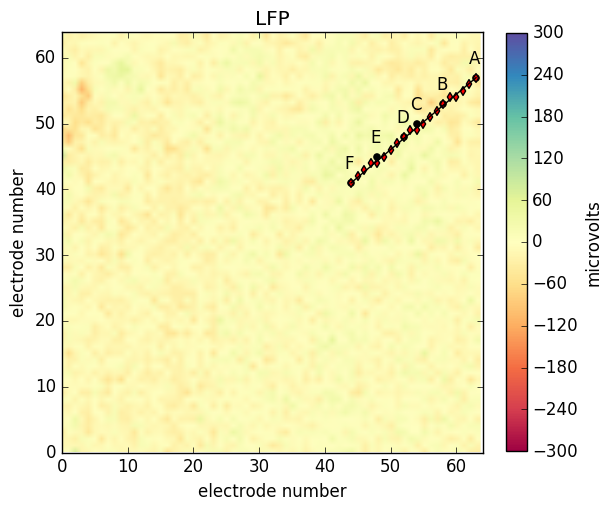

In [15]:
figure(figsize=(6,6.0))
title("LFP")
limites=300
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points")
end
imagen=imshow((DatosExperimentales[:,:,350]), cmap="Spectral", origin="lower", vmin=-limites, vmax=limites)

scatter(puntox,puntoy, marker="o", s=20, c="black")
scatter(xxs,yys, marker="d", s=20, c="r")

plot([44, 63], [41, 57], "k-")

cbx=colorbar(imagen, fraction=0.045) 
cbx[:set_label]("microvolts")
xlabel("electrode number")
ylabel("electrode number")

savefig("LFP_Recorded_350_with_selected_electrodes_01.png", dpi=90)

In [16]:
arregloparacascada=zeros(length(xxs),tmax);
for j in 1:length(xxs)
    arregloparacascada[j,:]=DatosExperimentales[xxs[j],yys[j],:]
end
#writedlm("LFP_spaciotemporal_01.dat", transpose(arregloparacascada))

In [17]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizar(Datos,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), collect(-medioancho:medioancho))
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end
    
GaussianKernel=readdlm("GaussianMatrix.dat")

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [18]:
LFPSuave=zeros(DatosExperimentales);
for j=1:64, k=1:64
    LFPSuave[j,k,:]=GaussSuavizar(reshape(DatosExperimentales[j,k,:],tmax),7)
end

In [19]:
LFPPlanchado=zeros(LFPSuave)
for t=1:tmax
    LFPPlanchado[:,:,t]=GaussianSmooth(LFPSuave[:,:,t])
end

In [20]:
#writedlm("LFP4AP_Planchado_01.dat", LFPPlanchado)

In [21]:
arregloparacascadaLFP=zeros(length(xxs),tmax);
for j in 1:length(xxs)
    arregloparacascadaLFP[j,:]=LFPPlanchado[xxs[j],yys[j],:]
end
#writedlm("LFPPlanchado_spaciotemporal_01.dat", transpose(arregloparacascadaLFP))

In [22]:
function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

In [23]:
LaplacianTerm1=[[0 1 0]; [1 -4 1]; [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5]; [0 -2 0]; [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [24]:
CSDPlanchada=zeros(LFPPlanchado)
for t=1:tmax
    CSDPlanchada[:,:,t]=-DiscreteLaplacian(LFPPlanchado[:,:,t])
end

In [25]:
#Tambien un arreglo para cascada del CSD
arregloparacascadacsd=zeros(arregloparacascada)
for j in 1:length(xxs)
    arregloparacascadacsd[j,:]=CSDPlanchada[xxs[j],yys[j],:]
end
writedlm("CSDPlanchado_spaciotemporal_01.dat", transpose(arregloparacascada))

In [26]:
size(arregloparacascadaLFP)

(20,1402)

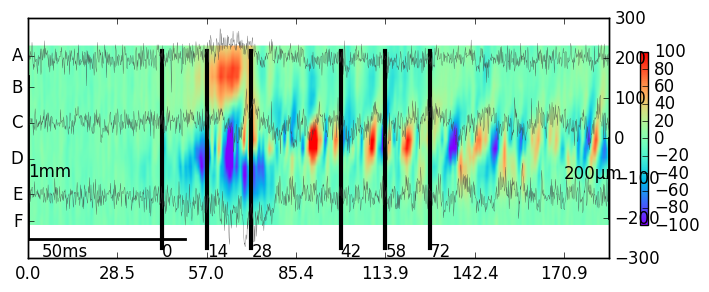

In [31]:
limites=100
fag, gaf=subplots(figsize=(8,3))
#The density plot
gaf[:set_xlim](1,1300)
gaf[:set_ylim](19.5,0)
imagen=gaf[:imshow](arregloparacascadaLFP, cmap="rainbow", vmin=-limites, vmax=limites)
tiempoestampas=gaf[:axes][:get_xticks]()
gaf[:plot]([0,351],[21,21], "k-", lw=2)
gaf[:annotate]("50ms", (30.5,23))
gaf[:plot]([0,0],[21,2.73], "k-", lw=2)
gaf[:annotate]("1mm", (0,14))

#Some vertical lines
gaf[:plot]([300,300],[22,0], "k-", lw=3)
gaf[:plot]([400,400],[22,0], "k-", lw=3)
gaf[:plot]([500,500],[22,0], "k-", lw=3)
gaf[:plot]([700,700],[22,0], "k-", lw=3)
gaf[:plot]([800,800],[22,0], "k-", lw=3)
gaf[:plot]([900,900],[22,0], "k-", lw=3)

gaf[:annotate]("0", (300,23))
gaf[:annotate]("14", (400,23))
gaf[:annotate]("28", (500,23))
gaf[:annotate]("42", (700,23))
gaf[:annotate]("58", (800,23))
gaf[:annotate]("72", (900,23))


#adjust aspcet ratioo
gaf[:axes][:set_aspect](20)
map!(x->round(x/7.0224,1), tiempoestampas)
gaf[:axes][:set_xticklabels](tiempoestampas)
gaf[:set_yticks]([19,16,12,8,4,0.5])
gaf[:set_yticklabels](puntol)


#colorbar
cbx=colorbar(imagen, fraction=0.014)

#the traces over the plot
ga2 = gaf[:twinx]()
ga2[:set_ylim](-300,300)

#ga2[:plot](1:1300, vec(arregloparacascada[19,1:1300])-200, "-", linewidth=0.2, color="0.25")
ga2[:plot](1:1300, vec(arregloparacascada[16,1:1300])-140, "-", linewidth=0.2, color="0.25")
#ga2[:plot](1:1300, vec(arregloparacascada[12,1:1300])-20, "-", linewidth=0.2 , color="0.25")
ga2[:plot](1:1300, vec(arregloparacascada[8,1:1300])+40, "-", linewidth=0.2, color="0.25")
#ga2[:plot](1:1300, vec(arregloparacascada[4,1:1300])+120, "-", linewidth=0.2, color="0.25")
ga2[:plot](1:1300, vec(arregloparacascada[1,1:1300])+200, "-", linewidth=0.2,color="0.25")
ga2[:plot]([1300,1300],[-200,0], "k-", lw=2)
ga2[:annotate]("200µm", (1200,-100))


ga2[:set_xlim](1,1300)
#ga2[:set_ylim](-300,300)

savefig("LFPRainbow-AF_timespaceBarras03.svg", dpi=90)

In [28]:
#savefig("LFPRainbow-AF_timespaceTest01.svg", dpi=90)
gaf=0
fag=0
tiempoestampas=0
profundidadestampas=0
close()

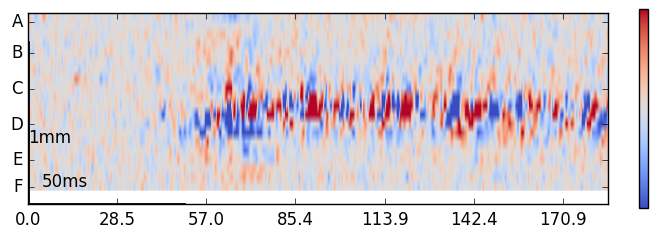

In [43]:
limites=20
figure(figsize=(8,3))
xlim(1,1300)
picts=imshow(arregloparacascadacsd, cmap="coolwarm",vmin=-limites, vmax=limites)
tiempoestampas=axes()[:get_xticks]()
map!(x->round(x/7.0224,1), tiempoestampas)
axes()[:set_xticklabels](tiempoestampas)
yticks([19,16,12,8,4,0.5])
axes()[:get_yticks]()
axes()[:set_yticklabels](puntol)


axes()[:set_aspect](20)

tick_params(axis="off", labelsize=14)

plot([0,351],[21,21], "k-", lw=2)
annotate("50ms", (30.5,19))
plot([0,0],[21,2.73], "k-", lw=2)
annotate("1mm", (0,14))
cb=colorbar(picts, ticks=[-150, +150], use_gridspec="True",fraction=0.016 )

savefig("CSD-AF_timespaceTest01.svg", dpi=90)


In [1]:
PyPlot.ion()
#################
font1 = Dict("family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>20)


t=850
seg=round(t/7022, 4)
titulo="$seg s"
figure(figsize=(6,5.5))
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)
#tick_params(labelbottom="off", labelleft="off")
otraimagen=imshow(CSDPlanchada[:,:,t], cmap="bwr", interpolation="spline16", origin="lower", vmin=-50, vmax=50)
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True",fraction=0.045 )
#farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)
tick_params(axis="both", labelsize=14)
#contour(0:63, 0:63, CSDPlanchada[:,:,t], levels=[-1,1])


annotate("Sink",
    xy=[1.07;-0.09],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14.0,
    ha="left",
    va="bottom")

annotate("Source",
    xy=[1.05;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14,
    ha="left",
   va="bottom")

xlabel("electrode number", fontsize=14)

ylabel("electrode number", fontsize=14)

title("CSD", fontdict=font1)

savefig("CSDPlanchada-$t.eps", dpi=90)

#tight_layout()

PyPlot.close_queued_figs()

LoadError: LoadError: UndefVarError: PyPlot not defined
while loading In[1], in expression starting on line 1

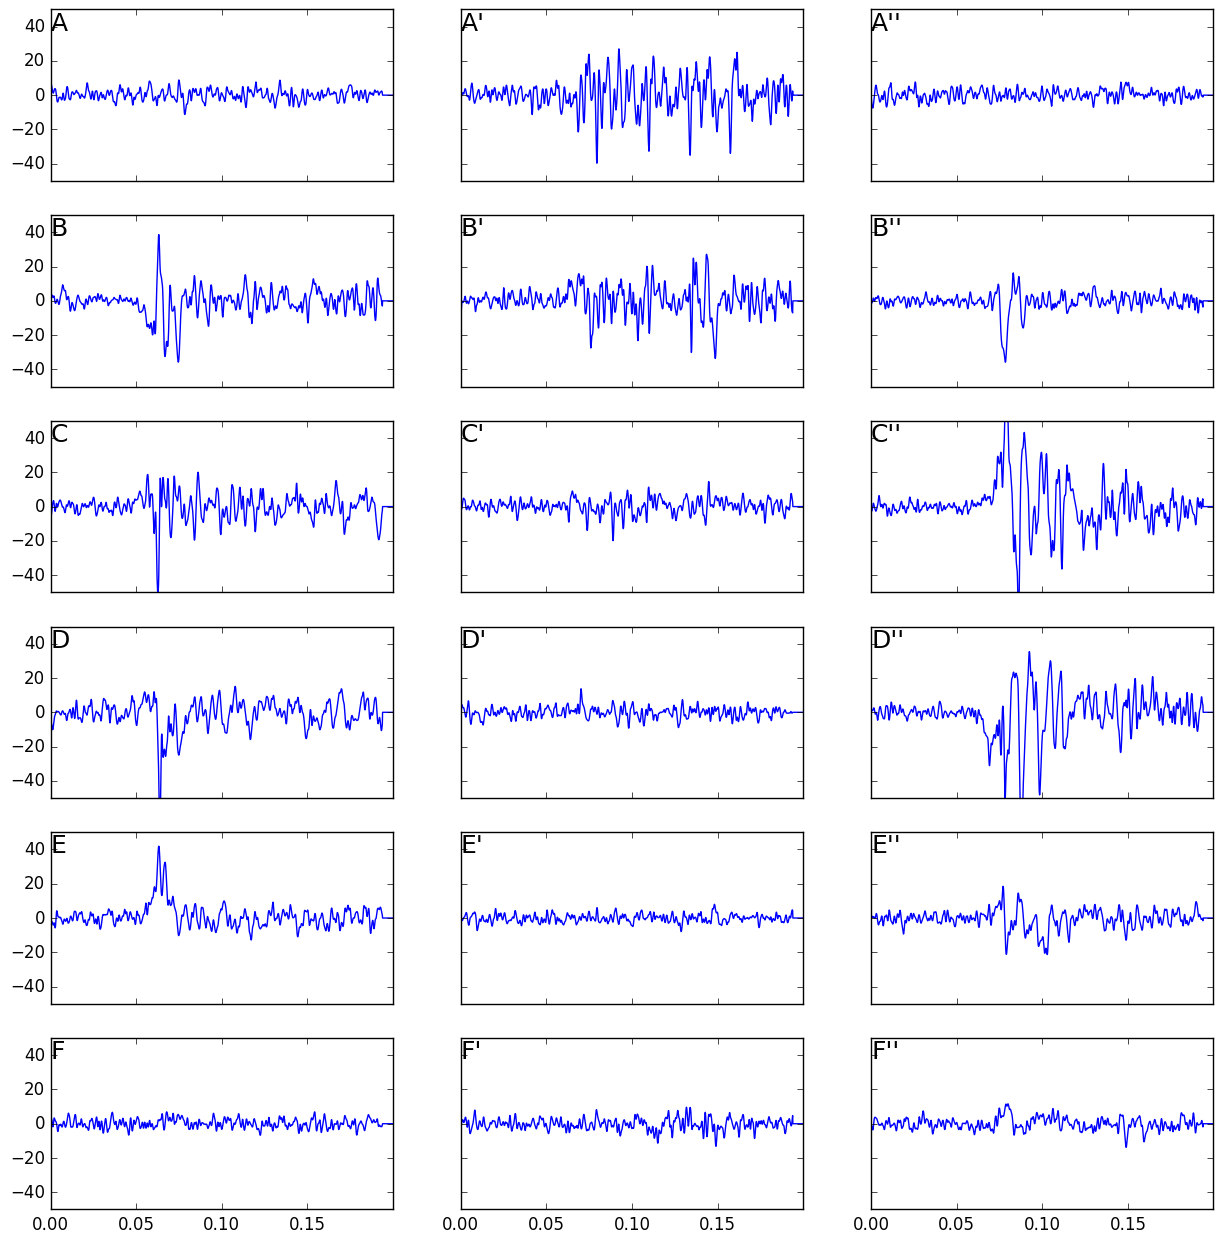

In [52]:
tiempo=1:tmax
t=700


farofa, lista=subplots(6,3, sharex=true, sharey=true, figsize=(15,6*2.5), frameon="false")

for j=1:6
    PyPlot.xlim(1/7022,tmax/7022)
    PyPlot.ylim(-50,50)
    lista[j,1][:plot](tiempo/7022,vec(CSDPlanchada[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j,1][:annotate](puntol[7-j],xy=(0.0,38), annotation_clip=false, fontsize=18)
    
    lista[j,2][:plot](tiempo/7022,vec(CSDPlanchada[primay[7-j],primax[7-j],tiempo]))
    lista[j,2][:annotate](primal[7-j],xy=(0.00,38), annotation_clip=false, fontsize=18)
    
    lista[j,3][:plot](tiempo/7022,vec(CSDPlanchada[dobleprimay[7-j],dobleprimax[7-j],tiempo]))
    lista[j,3][:annotate](dobleprimal[7-j],xy=(0.0,38), annotation_clip=false, fontsize=18)
end

savefig("CSD_A-F_yOtros_Points_01.svg",dpi=90)

In [52]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end

function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

In [53]:
function ObtenComponentesYEscribe(Datos::Array, tini=1, tfini=tmax)

 for t=tini:tfini
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    SpikeCountPositivo=zeros(64,64)
    SpikeCountNegativo=zeros(64,64)
    #Todos
    for j=1:64, k=1:64
            if(Datos[j,k,t]<-0.0)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,t]>0.0)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                        deleteat!(listaneg, indexin(Any[v], listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasaneg=vcat(centrosdemasaneg, A)
    end
    centrosdemasaneg=centrosdemasaneg[2:end,:]
    zacatlan="GarbageCollector/CMPozos-$t.dat"
    writedlm(zacatlan, centrosdemasaneg)
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                        deleteat!(listapos, indexin(Any[v], listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasapos=vcat(centrosdemasapos, A)
    end
    centrosdemasapos=centrosdemasapos[2:end,:]
    zacatlan="GarbageCollector/CMFuentes-$t.dat"
    writedlm(zacatlan, centrosdemasapos)
end
    return curlab
end

ObtenComponentesYEscribe (generic function with 3 methods)

In [50]:
size(CSDPlanchada)

(64,64,1402)

In [ ]:
ObtenComponentesYEscribe(CSDPlanchada, 1, 1402)

In [57]:
t=550
EjemploCentrosCSDPos=readdlm("GarbageCollector/CentrosDeMasaParaPoster/CMFuentes-550.dat")
EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
xxpos=EjemploCentrosCSDPos[:,1]
yypos=EjemploCentrosCSDPos[:,2]
valorpos=EjemploCentrosCSDPos[:,3]
EjemploCentrosCSDNeg=readdlm("GarbageCollector/CentrosDeMasaParaPoster/CMPozos-550.dat")
EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)
xxneg=EjemploCentrosCSDNeg[:,1]
yyneg=EjemploCentrosCSDNeg[:,2]
valorneg=EjemploCentrosCSDNeg[:,3];
CSDEjemplo=CSDPlanchada[:,:,550];

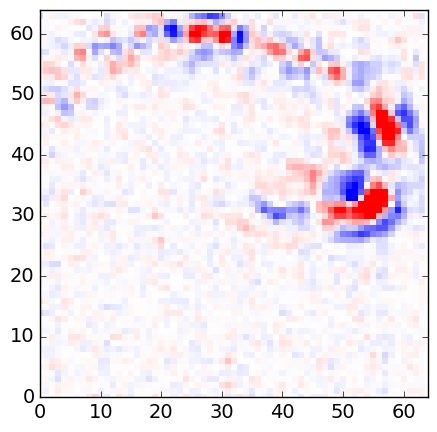

false

In [63]:
PyPlot.ion()
#################
font1 = Dict("family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>20)
seg=round(t/7022, 4)
titulo="$seg s"
figure(figsize=(5,5))
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

otraimagen=imshow(CSDEjemplo, cmap="bwr", origin="lower", vmin=-50, vmax=50, interpolation="none")
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
#cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True")
#farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)

#scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r", edgecolors="none")
#scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g", edgecolors="none")
#scatter(xxpos,yypos, s=0.02*valorpos, alpha=0.9, c="yellow", edgecolors="black")
#scatter(xxneg, yyneg,s=0.02*abs(valorneg), alpha=0.9, c="green", edgecolors="black")

tick_params(axis="both", labelsize=14)

#title(titulo, fontdict=font1)
 #tight_layout()
savefig("CSDParaDisjoint-550.svg", dpi=90)
PyPlot.close_queued_figs()

In [64]:
writedlm("CSDForLineArtAbove-550.dat", CSDEjemplo)

In [56]:
PyPlot.ioff()
#################
font1 = Dict("family"=>"DejaVu Serif",
    "color"=>"black",
    "weight"=>"normal",
    "size"=>20)


for t=300:100:900

seg=round((t-300)/7.022, 1)
titulo="$seg ms"
figure(figsize=(6,5.5))
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)
#tick_params(labelbottom="off", labelleft="off")
otraimagen=imshow(CSDPlanchada[:,:,t], cmap="bwr", interpolation="spline16", origin="lower", vmin=-50, vmax=50)
#cb=colorbar(otraimagen)
#cb=colorbar(otraimagen, ticks=[-150, +150],fraction=0.046, pad=0.04, use_gridspace='True')
cb=colorbar(otraimagen, ticks=[-150, +150], use_gridspec="True",fraction=0.045 )
#farofa=cb[:set_ticklabels]([{"Sink"}, {"Source"}])
#xlabel("furufu", fontdict=font1)
tick_params(axis="both", labelsize=14)
#contour(0:63, 0:63, CSDPlanchada[:,:,t], levels=[-1,1])


annotate("Sink",
    xy=[1.07;-0.09],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14.0,
    ha="left",
    va="bottom")

annotate("Source",
    xy=[1.05;0.98],
    xycoords="axes fraction",
    xytext=[-10,10],
    textcoords="offset points",
    fontsize=14,
    ha="left",
   va="bottom")

xlabel("electrode number", fontsize=14)

ylabel("electrode number", fontsize=14)

    title(titulo, fontdict=font1)

    savefig("CSDPlanchadaSinLabels-$t.svg", dpi=90)

end
#tight_layout()

PyPlot.close_queued_figs()